# Figure 2b

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
texture_1 = plt.imread('../data/texture1.jpg').astype(np.float32)
h, w, c = texture_1.shape
block_size = 100
overlap_size = int(block_size / 6)
assert block_size < min(h, w)
y_max, x_max = h - block_size, w - block_size
dh = h * 2
dw = w * 2
nx_blocks = ny_blocks = max(dh, dw) // block_size
w_new = h_new = nx_blocks * block_size - (nx_blocks - 1) * overlap_size
n_blocks = nx_blocks * ny_blocks
xs = np.arange(x_max)
ys = np.arange(y_max)
all_blocks = np.array([texture_1[y:y + block_size, x:x + block_size] for x in xs for y in ys])

In [3]:
# normalize_img normalizes our output to be between 0 and 1
def normalize_img(im):
    img = im.copy()
    img += np.abs(np.min(img))
    img /= np.max(img)
    return img

def l2_top_bottom(patch_top, patch_bottom):
    block_top  = patch_top[-overlap_size:, :]
    
    if patch_bottom.ndim == 3:
        block_bottom = patch_bottom[:overlap_size]
    elif patch_bottom.ndim == 4:
        block_bottom = patch_bottom[:, :overlap_size]
        
    top_cost  = l2_loss(block_top, block_bottom)
    
    return top_cost

def l2_left_right(patch_left, patch_right):
    block_left  = patch_left[:, -overlap_size:]
    
    if patch_right.ndim == 3:
        block_right = patch_right[:, :overlap_size]
    elif patch_right.ndim == 4:
        block_right = patch_right[:, :, :overlap_size]

    left_cost  = l2_loss(block_left, block_right)
    
    return left_cost

def l2_loss(block_1, block_2):
    sqdfs = np.sum((block_1 - block_2) ** 2, axis=-1)
    return np.sqrt(np.sum(np.sum(sqdfs, axis=-1), axis=-1))

def select_min_patch(patches, cost):
    return patches[np.argmin(cost)]

C:\Users\lousc\Anaconda3\envs\py3-6\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt


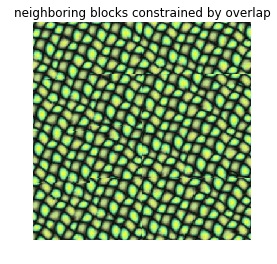

In [4]:
target_height = h_new
target_width = w_new
target = np.zeros((target_height, target_width, c), dtype=texture_1.dtype)

step = block_size - overlap_size

y_begin = 0
y_end = block_size

for y in range(ny_blocks):
    
    x_begin = 0
    x_end = block_size
    
    for x in range(nx_blocks):
        if x == 0 and y == 0:
            # randomly select top left patch
            r = np.random.randint(len(all_blocks))
            random_patch = all_blocks[r]
            target[y_begin:y_end, x_begin:x_end] = random_patch
            
            x_begin = x_end
            x_end  += step
            
            continue
        
        xa, xb = x_begin - block_size, x_begin
        ya, yb = y_begin - block_size, y_begin
        
        if y == 0:
            y1 = 0
            y2 = block_size
            
            left_patch = target[y1:y2, xa:xb]
            left_block = left_patch[:, -overlap_size:]
            left_cost  = l2_left_right(patch_left=left_patch, patch_right=all_blocks)
            best_right_patch = select_min_patch(all_blocks, left_cost)
            
            best_right_block = best_right_patch[:, :overlap_size]

            # join left and right blocks
            left_right_join = np.hstack((left_block[:, :overlap_size//2], best_right_block[:, overlap_size//2:]))
            full_join = np.hstack((target[y1:y2, xa:xb-overlap_size], left_right_join, best_right_patch[:, overlap_size:]))

            target[y1:y2, xa:x_end] = full_join
        else:
            if x == 0:
                x1 = 0
                x2 = block_size
                top_patch = target[ya:yb, x1:x2]
                top_block = top_patch[-overlap_size:, :]
                top_cost = l2_top_bottom(patch_top=top_patch, patch_bottom=all_blocks)
                best_bottom_patch = select_min_patch(all_blocks, top_cost)
                best_bottom_block = best_bottom_patch[:overlap_size, :]

                # join top and bottom blocks
                top_bottom_join = np.vstack((top_block[:overlap_size//2, :], best_bottom_block[overlap_size//2:, :]))
                full_join = np.vstack((target[ya:yb-overlap_size, x1:x2], top_bottom_join, best_bottom_patch[overlap_size:, :]))

                target[ya:y_end, x1:x2] = full_join
            else:
                # overlap is L-shaped
                y1, y2 = y_begin - overlap_size, y_end
                x1, x2 = x_begin - overlap_size, x_end

                left_patch = target[y1:y2, xa:xb]
                top_patch = target[ya:yb, x1:x2]
                
                left_block = left_patch[:, -overlap_size:]
                top_block = top_patch[-overlap_size:, :]
                
                left_cost  = l2_left_right(patch_left=left_patch, patch_right=all_blocks)
                top_cost = l2_top_bottom(patch_top=top_patch, patch_bottom=all_blocks)
                
                best_right_patch = best_bottom_patch = select_min_patch(all_blocks, top_cost + left_cost)
                
                best_right_block = best_right_patch[:, :overlap_size]
                best_bottom_block = best_bottom_patch[:overlap_size, :]
                
                # join left and right blocks
                left_right_join = np.hstack((left_block[:, :overlap_size//2], best_right_block[:, overlap_size//2:]))
                full_lr_join = np.hstack((target[y1:y2, xa:xb-overlap_size], left_right_join, best_right_patch[:, overlap_size:]))
                
                # join top and bottom blocks
                top_bottom_join = np.vstack((top_block[:overlap_size//2, :], best_bottom_block[overlap_size//2:, :]))
                full_tb_join = np.vstack((target[ya:yb-overlap_size, x1:x2], top_bottom_join, best_bottom_patch[overlap_size:, :]))

                target[ya:y_end, x1:x2] = full_tb_join
                target[y1:y2, xa:x_end] = full_lr_join
                
        x_begin = x_end
        x_end  += step

    y_begin = y_end
    y_end  += step

plt.title('neighboring blocks constrained by overlap')
plt.imshow(normalize_img(target))
plt.axis('off')
plt.show()

In [5]:
plt.imsave('figure2b.jpg', normalize_img(target))